In [1]:
#On importe pour ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

# 0. On importe les packages nécessaires pour la manipulation des données

In [2]:
# --- Core Data Manipulation Libraries ---
import numpy as np
import pandas as pd
from datetime import datetime
import os
import sys
import json
from pathlib import Path

## 0.1 On définit différentes fonctions utilitaires

In [3]:
def print_divider(title="", width=80, style="="):
    """
    Create a formatted section divider for better readability
    """
    if title:
        side_width = (width - len(title) - 2) // 2
        print(f"\n{style * side_width} {title} {style * side_width}")
    else:
        print(f"\n{style * width}")

def describe_dataframe(df, name="DataFrame"):
    """
    Comprehensive DataFrame description with memory usage and data types
    """
    print_divider(f"{name} Overview")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\nData Types:")
    print(df.dtypes.value_counts())
    print(f"\nMissing Values: {df.isnull().sum().sum()}")
    print(f"Duplicate Rows: {df.duplicated().sum()}")
    
    return df.info()

def calculate_vif(df, features):
    """
    Calculate Variance Inflation Factor for multicollinearity detection
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) 
                       for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

# 1. Chargement des données

In [4]:
# ============================================================================
# Chargement des données et inspection initiale
# ============================================================================

print_divider("PHASE DE CHARGEMENT DES DONNÉES", style="=")

# Define the data path
DATA_PATH = '../data/raw/dirty_v3_path.csv'

# Load data with error handling
try:
    # Load the dataset
    df_raw = pd.read_csv(DATA_PATH)
    print(f"✅ Data loaded successfully from: {DATA_PATH}")
    
    # Create a backup of raw data
    df = df_raw.copy()
    print("✅ Backup of raw data created")
    
except FileNotFoundError:
    print(f"❌ Error: File not found at {DATA_PATH}")
    print("Please check the file path and try again.")
except Exception as e:
    print(f"❌ Unexpected error: {e}")

# Initial data inspection
describe_dataframe(df, "Healthcare Dataset")


======================= PHASE DE CHARGEMENT DES DONNÉES =======================
✅ Data loaded successfully from: ../data/raw/dirty_v3_path.csv
✅ Backup of raw data created

========================= Healthcare Dataset Overview =========================
Shape: 30000 rows × 20 columns
Memory Usage: 8.39 MB

Data Types:
float64    13
int64       4
object      3
Name: count, dtype: int64

Missing Values: 22500
Duplicate Rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                25500 non-null  float64
 1   Gender             25500 non-null  object 
 2   Medical Condition  25500 non-null  object 
 3   Glucose            25500 non-null  float64
 4   Blood Pressure     25500 non-null  float64
 5   BMI                30000 non-null  float64
 6   Oxygen Saturation  30000 non-null  float64
 7   LengthOfStay       30000 

In [5]:
#on définit un random seed pour la reproductibilité
RANDOM_STATE = 42

print(f"✅ Graîne aléatoire définie à : {RANDOM_STATE}")

✅ Graîne aléatoire définie à : 42


## 1.1 Premier regard sur les données

In [6]:
print_divider("Nom des colonnes du DataFrame", style="-")

#On met en minuscule le nom des colonnes, on remplace les espaces par des underscores et on supprime les caractères spéciaux
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(r"[^a-zA-Z0-9_]", "")

print(df.columns.tolist())
print("✅ Noms des colonnes standardisés")


------------------------ Nom des colonnes du DataFrame ------------------------
['age', 'gender', 'medical_condition', 'glucose', 'blood_pressure', 'bmi', 'oxygen_saturation', 'lengthofstay', 'cholesterol', 'triglycerides', 'hba1c', 'smoking', 'alcohol', 'physical_activity', 'diet_score', 'family_history', 'stress_level', 'sleep_hours', 'random_notes', 'noise_col']
✅ Noms des colonnes standardisés


In [7]:
print_divider("10 premières données", style="=")
display(df.head(10))

print_divider("10 dernières données", style="=")
display(df.tail(10))

print_divider("10 données aléatoires", style="=")
display(df.sample(10))

print_divider("Statistiques descriptives", style="=")
display(df.describe(include='all').round(2))


============================= 10 premières données =============================


age  gender medical_condition  glucose  blood_pressure    bmi  \
0  46.0    Male          Diabetes   137.04          135.27  28.90   
1  22.0    Male           Healthy    71.58          113.27  26.29   
2  50.0     NaN            Asthma    95.24             NaN  22.53   
3  57.0     NaN           Obesity      NaN          130.53  38.47   
4  66.0  Female      Hypertension    95.15          178.17  31.12   
5  50.0    Male      Hypertension   107.00          171.80  25.33   
6  80.0    Male      Hypertension      NaN          174.52  29.87   
7  50.0    Male            Cancer      NaN          136.13  26.37   
8  60.0  Female           Obesity      NaN             NaN  35.49   
9  13.0  Female            Asthma    90.60          126.88  29.24   

   oxygen_saturation  lengthofstay  cholesterol  triglycerides  hba1c  \
0              96.04             6       231.88         210.56   7.61   
1              97.54             2       165.57         129.41   4.91   
2              90.31             2       214.94         165.35   5.60   
3              96.60             5       197.71         182.13   6.92   
4              94.90             4       259.53         115.85   5.98   
5              95.21             5       233.10         203.67   5.48   
6              97.96             3       247.11         128.27   5.99   
7              82.72            19       209.26         137.79   6.23   
8              98.62             3       264.69         194.21   6.83   
9              97.96             6       193.44         163.65   6.18   

   smoking  alcohol  physical_activity  diet_score  family_history  \
0        0        0              -0.20        3.54               0   
1        0        0               8.12        5.90               0   
2        0        0               5.01        4.65               1   
3        0        0               3.16        3.37               0   
4        0        1               3.56        3.40               0   
5        1        0               5.01        4.65               0   
6        1        1               1.92        5.76               1   
7        1        0               5.34        3.34               0   
8        0        0               1.66        2.99               0   
9        1        0               5.27        5.63               0   

   stress_level  sleep_hours random_notes   noise_col  
0          5.07         6.05        lorem -137.057211  
1          5.87         7.72        ipsum  -11.230610  
2          3.09         4.82        ipsum   98.331195  
3          3.01         5.33        lorem   44.187175  
4          6.38         6.64        lorem   44.831426  
5          7.25         6.35        ipsum  108.411983  
6          8.25         7.23        ipsum    7.009539  
7          8.76         4.94          ###   64.247308  
8          5.93         5.87        lorem   45.855558  
9          7.09         5.41        lorem  -45.916696


============================= 10 dernières données =============================


age  gender medical_condition  glucose  blood_pressure    bmi  \
29990  43.0    Male          Diabetes      NaN          132.31  19.80   
29991  63.0     NaN         Arthritis   104.98          104.02  26.91   
29992  62.0    Male      Hypertension      NaN          105.42  27.18   
29993  48.0  Female               NaN   107.09          163.32  34.40   
29994  76.0     NaN      Hypertension    97.17          138.92  25.65   
29995  54.0  Female           Healthy    86.35          127.68  28.30   
29996  41.0    Male            Asthma    89.24          154.37  24.93   
29997  83.0  Female               NaN      NaN          170.11  30.55   
29998  41.0    Male          Diabetes   242.87          152.97  23.57   
29999  46.0  Female      Hypertension    86.52          159.26  34.55   

       oxygen_saturation  lengthofstay  cholesterol  triglycerides  hba1c  \
29990              94.04             3       190.63         146.06   7.93   
29991              97.90             4       203.70         230.14   6.00   
29992              95.31             2       183.59         192.10   6.36   
29993              94.47             2       236.15         181.37   5.43   
29994              93.99             3       235.65         238.26   6.43   
29995              94.36             1       218.60         152.82   4.85   
29996              96.07             4       198.30         176.81   5.36   
29997              97.83             3       210.13         168.76   5.05   
29998              99.17             3       208.86         224.21   7.59   
29999              96.60             4       217.37         141.28   5.77   

       smoking  alcohol  physical_activity  diet_score  family_history  \
29990        0        0               4.13        3.73               1   
29991        0        1               3.18        0.99               1   
29992        1        1               5.40        4.93               0   
29993        0        0               4.43        4.93               1   
29994        0        0               3.14        3.46               0   
29995        0        0               9.15       10.35               0   
29996        1        0               3.34        3.40               0   
29997        0        0               4.53        4.50               0   
29998        0        0               3.16        2.59               0   
29999        1        0               4.91        5.82               1   

       stress_level  sleep_hours random_notes   noise_col  
29990          3.75         6.90           ??  122.467920  
29991          5.04         6.85        ipsum  -56.102577  
29992          5.46         3.99        lorem  140.731299  
29993          7.55         3.72        lorem  -35.728961  
29994          6.66         6.10        ipsum   37.705013  
29995          3.65         8.71        ipsum   89.573837  
29996          6.72         2.81        lorem   -5.864517  
29997          4.31         3.61          ###  -30.934595  
29998          7.10         5.80        ipsum    5.085258  
29999          3.64         5.47        lorem -142.559559


============================ 10 données aléatoires ============================


age  gender medical_condition  glucose  blood_pressure    bmi  \
9982   61.0     NaN               NaN   195.14          148.05  31.27   
28122  13.0  Female            Asthma      NaN          121.09  16.50   
17285  59.0    Male          Diabetes      NaN             NaN  24.15   
9463   48.0     NaN          Diabetes    97.62          141.45  24.19   
15728  74.0  Female          Diabetes   233.93          133.43  30.06   
13319   NaN  Female           Obesity    93.19             NaN  37.83   
28429  54.0    Male            Asthma   124.54          122.75  22.47   
11975  62.0     NaN            Cancer   111.54          132.35  33.38   
23769  69.0  Female          Diabetes      NaN          138.81  32.25   
24389  67.0    Male           Healthy    75.99          126.02  29.92   

       oxygen_saturation  lengthofstay  cholesterol  triglycerides  hba1c  \
9982               96.77             7       178.66         156.39   7.49   
28122              78.17             3       241.46         216.73   5.79   
17285              94.58             5       229.35          99.43   7.97   
9463               95.74             4       213.93         166.58   6.63   
15728              95.88             3       172.65         130.23   6.54   
13319              95.02             2       228.02         231.08   5.92   
28429              88.15             3       235.20         190.24   5.67   
11975              83.71            18       193.89         189.43   4.91   
23769              94.05             6       241.64         160.13   6.01   
24389              95.56             2       191.62         143.49   4.98   

       smoking  alcohol  physical_activity  diet_score  family_history  \
9982         0        0               2.26        3.56               0   
28122        0        0               4.78        4.49               0   
17285        1        0               3.11        2.07               1   
9463         0        0               1.65        2.73               1   
15728        0        0               0.10        2.64               1   
13319        1        0               2.03        3.29               0   
28429        1        0               7.14        5.09               0   
11975        1        0               3.52        7.24               0   
23769        0        1               2.73        3.83               0   
24389        0        0               5.37        6.30               0   

       stress_level  sleep_hours random_notes   noise_col  
9982           5.27         6.35           ??   29.281019  
28122         10.51         5.14          ###  -90.309048  
17285          6.82         4.43          ###  -22.587770  
9463           7.25         6.33          ###  109.817543  
15728          6.88         6.07        ipsum -198.707711  
13319          8.02         7.24        lorem  -22.238846  
28429          1.51         4.92        ipsum  138.800377  
11975          9.30         4.49        lorem   -6.616239  
23769          7.76         6.41        lorem   54.151677  
24389          3.61         7.41        ipsum   48.282193


========================== Statistiques descriptives ==========================


age  gender medical_condition   glucose  blood_pressure  \
count   25500.00   25500             25500  25500.00        25500.00   
unique       NaN       2                 7       NaN             NaN   
top          NaN  Female      Hypertension       NaN             NaN   
freq         NaN   12865              7120       NaN             NaN   
mean       54.62     NaN               NaN    123.62          140.46   
std        15.97     NaN               NaN     41.58           21.08   
min        10.00     NaN               NaN     20.32           74.24   
25%        45.00     NaN               NaN     96.28          125.14   
50%        55.00     NaN               NaN    110.50          138.32   
75%        66.00     NaN               NaN    136.61          153.79   
max        89.00     NaN               NaN    318.51          226.38   

             bmi  oxygen_saturation  lengthofstay  cholesterol  triglycerides  \
count   30000.00           30000.00      30000.00     30000.00       30000.00   
unique       NaN                NaN           NaN          NaN            NaN   
top          NaN                NaN           NaN          NaN            NaN   
freq         NaN                NaN           NaN          NaN            NaN   
mean       28.48              94.95          4.41       213.03         176.84   
std         5.73               3.74          2.76        33.52          48.81   
min         7.67              67.51          1.00        95.73         -22.48   
25%        24.59              93.00          3.00       189.50         141.28   
50%        28.05              95.30          4.00       211.84         173.36   
75%        31.81              97.38          5.00       235.31         208.63   
max        56.85             110.07         19.00       358.37         421.51   

           hba1c   smoking   alcohol  physical_activity  diet_score  \
count   30000.00  30000.00  30000.00           30000.00    30000.00   
unique       NaN       NaN       NaN                NaN         NaN   
top          NaN       NaN       NaN                NaN         NaN   
freq         NaN       NaN       NaN                NaN         NaN   
mean        6.29      0.28      0.24               3.80        4.03   
std         1.32      0.45      0.43               2.01        1.82   
min         3.28      0.00      0.00              -3.68       -1.75   
25%         5.33      0.00      0.00               2.35        2.77   
50%         5.97      0.00      0.00               3.59        3.79   
75%         6.92      1.00      0.00               5.06        5.02   
max        12.36      1.00      1.00              12.41       12.06   

        family_history  stress_level  sleep_hours random_notes  noise_col  
count         30000.00      30000.00     30000.00        30000   30000.00  
unique             NaN           NaN          NaN            4        NaN  
top                NaN           NaN          NaN          ###        NaN  
freq               NaN           NaN          NaN         7575        NaN  
mean              0.44          5.92         6.23          NaN      -0.52  
std               0.50          2.23         1.19          NaN     100.08  
min               0.00         -2.44         1.59          NaN    -412.17  
25%               0.00          4.37         5.41          NaN     -68.27  
50%               0.00          5.90         6.23          NaN      -0.51  
75%               1.00          7.44         7.05          NaN      66.81  
max               1.00         15.45        10.35          NaN     467.89

In [8]:
print_divider("Standardisation des données", style = "=")
#on mets les chaines de caractères en minuscules et on supprime les espaces avant et après
str_cols = df.select_dtypes(include=['object', 'category']).columns
for col in str_cols:
    df[col] = df[col].str.lower().str.strip().str.replace(" ", "_")

df.head()


========================= Standardisation des données =========================


age  gender medical_condition  glucose  blood_pressure    bmi  \
0  46.0    male          diabetes   137.04          135.27  28.90   
1  22.0    male           healthy    71.58          113.27  26.29   
2  50.0     NaN            asthma    95.24             NaN  22.53   
3  57.0     NaN           obesity      NaN          130.53  38.47   
4  66.0  female      hypertension    95.15          178.17  31.12   

   oxygen_saturation  lengthofstay  cholesterol  triglycerides  hba1c  \
0              96.04             6       231.88         210.56   7.61   
1              97.54             2       165.57         129.41   4.91   
2              90.31             2       214.94         165.35   5.60   
3              96.60             5       197.71         182.13   6.92   
4              94.90             4       259.53         115.85   5.98   

   smoking  alcohol  physical_activity  diet_score  family_history  \
0        0        0              -0.20        3.54               0   
1        0        0               8.12        5.90               0   
2        0        0               5.01        4.65               1   
3        0        0               3.16        3.37               0   
4        0        1               3.56        3.40               0   

   stress_level  sleep_hours random_notes   noise_col  
0          5.07         6.05        lorem -137.057211  
1          5.87         7.72        ipsum  -11.230610  
2          3.09         4.82        ipsum   98.331195  
3          3.01         5.33        lorem   44.187175  
4          6.38         6.64        lorem   44.831426

## 1.2 Qualité des données

In [17]:
print_divider("DATA QUALITY REPORT", style="=")

# Create comprehensive quality report
quality_report = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Null Count': df.isnull().sum().values,
    'Null %': (df.isnull().sum().values / len(df) * 100).round(2),
    'Unique Values': df.nunique().values,
    'Unique %': (df.nunique().values / len(df) * 100).round(2)
})

# Add additional metrics for numeric columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
print(numeric_cols)
for col in numeric_cols:
    quality_report.loc[quality_report['Column'] == col, 'Min'] = df[col].min()
    quality_report.loc[quality_report['Column'] == col, 'Max'] = df[col].max()
    quality_report.loc[quality_report['Column'] == col, 'Mean'] = round(df[col].mean(), 2)
    quality_report.loc[quality_report['Column'] == col, 'Std'] = round(df[col].std(), 2)

display(quality_report)


============================= DATA QUALITY REPORT =============================
Index(['age', 'glucose', 'blood_pressure', 'bmi', 'oxygen_saturation',
       'lengthofstay', 'cholesterol', 'triglycerides', 'hba1c', 'smoking',
       'alcohol', 'physical_activity', 'diet_score', 'family_history',
       'stress_level', 'sleep_hours', 'noise_col'],
      dtype='object')


Column Data Type  Non-Null Count  Null Count  Null %  \
0                 age   float64           25500        4500    15.0   
1              gender    object           25500        4500    15.0   
2   medical_condition    object           25500        4500    15.0   
3             glucose   float64           25500        4500    15.0   
4      blood_pressure   float64           25500        4500    15.0   
5                 bmi   float64           30000           0     0.0   
6   oxygen_saturation   float64           30000           0     0.0   
7        lengthofstay     int64           30000           0     0.0   
8         cholesterol   float64           30000           0     0.0   
9       triglycerides   float64           30000           0     0.0   
10              hba1c   float64           30000           0     0.0   
11            smoking     int64           30000           0     0.0   
12            alcohol     int64           30000           0     0.0   
13  physical_activity   float64           30000           0     0.0   
14         diet_score   float64           30000           0     0.0   
15     family_history     int64           30000           0     0.0   
16       stress_level   float64           30000           0     0.0   
17        sleep_hours   float64           30000           0     0.0   
18       random_notes    object           30000           0     0.0   
19          noise_col   float64           30000           0     0.0   

    Unique Values  Unique %         Min        Max    Mean     Std  
0              80      0.27   10.000000   89.00000   54.62   15.97  
1               2      0.01         NaN        NaN     NaN     NaN  
2               7      0.02         NaN        NaN     NaN     NaN  
3           11097     36.99   20.320000  318.51000  123.62   41.58  
4            8259     27.53   74.240000  226.38000  140.46   21.08  
5            3097     10.32    7.670000   56.85000   28.48    5.73  
6            2267      7.56   67.510000  110.07000   94.95    3.74  
7              19      0.06    1.000000   19.00000    4.41    2.76  
8           12021     40.07   95.730000  358.37000  213.03   33.52  
9           14840     49.47  -22.480000  421.51000  176.84   48.81  
10            770      2.57    3.280000   12.36000    6.29    1.32  
11              2      0.01    0.000000    1.00000    0.28    0.45  
12              2      0.01    0.000000    1.00000    0.24    0.43  
13           1154      3.85   -3.680000   12.41000    3.80    2.01  
14           1103      3.68   -1.750000   12.06000    4.03    1.82  
15              2      0.01    0.000000    1.00000    0.44    0.50  
16           1300      4.33   -2.440000   15.45000    5.92    2.23  
17            745      2.48    1.590000   10.35000    6.23    1.19  
18              4      0.01         NaN        NaN     NaN     NaN  
19          30000    100.00 -412.169596  467.89491   -0.52  100.08

In [28]:
df["medical_condition"].unique()

array(['diabetes', 'healthy', 'asthma', 'obesity', 'hypertension',
       'cancer', nan, 'arthritis'], dtype=object)

In [20]:
# Check for data anomalies
print_divider("DATA ANOMALY CHECK")

anomalies = []
for col in numeric_cols:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        print(f"⚠️ {col}: {neg_count} valeurs négatives trouvées")
        anomalies.append(f"{col}")
    else:
        print(f"✅ {col}: Aucune valeur négative trouvée")

print(anomalies)



============================== DATA ANOMALY CHECK ==============================
✅ age: Aucune valeur négative trouvée
✅ glucose: Aucune valeur négative trouvée
✅ blood_pressure: Aucune valeur négative trouvée
✅ bmi: Aucune valeur négative trouvée
✅ oxygen_saturation: Aucune valeur négative trouvée
✅ lengthofstay: Aucune valeur négative trouvée
✅ cholesterol: Aucune valeur négative trouvée
⚠️ triglycerides: 4 valeurs négatives trouvées
✅ hba1c: Aucune valeur négative trouvée
✅ smoking: Aucune valeur négative trouvée
✅ alcohol: Aucune valeur négative trouvée
⚠️ physical_activity: 302 valeurs négatives trouvées
⚠️ diet_score: 105 valeurs négatives trouvées
✅ family_history: Aucune valeur négative trouvée
⚠️ stress_level: 67 valeurs négatives trouvées
✅ sleep_hours: Aucune valeur négative trouvée
⚠️ noise_col: 15063 valeurs négatives trouvées
['triglycerides', 'physical_activity', 'diet_score', 'stress_level', 'noise_col']


In [24]:
#on remplace les valeurs négatives par des NaN
for col in anomalies:
    df.loc[df[col] < 0, col] = np.nan

In [25]:
print_divider("Recherche d'éventuels doublons", style="=")

dup_count = df.duplicated().sum()
if dup_count > 0:
    print(f"⚠️ Attention: {dup_count} lignes dupliquées trouvées.")
    display(df[df.duplicated(keep=False)].sort_values(df.columns.tolist()))
else:
    print("✅ Aucune ligne dupliquée trouvée.")


======================== Recherche d'éventuels doublons ========================
✅ Aucune ligne dupliquée trouvée.


In [26]:
print_divider("Recherche des valeurs aberrantes", style="=")

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    outlier_count = len(outliers)
    
    if outlier_count > 0:
        print(f"📊 {col}:")
        print(f"   - Outliers: {outlier_count} ({outlier_count/len(df)*100:.2f}%)")
        print(f"   - Lower Bound: {lower_bound:.2f}")
        print(f"   - Upper Bound: {upper_bound:.2f}")
        print(f"   - Outlier Range: [{outliers[col].min():.2f}, {outliers[col].max():.2f}]")


======================= Recherche des valeurs aberrantes =======================
📊 age:
   - Outliers: 163 (0.54%)
   - Lower Bound: 13.50
   - Upper Bound: 97.50
   - Outlier Range: [10.00, 13.00]
📊 glucose:
   - Outliers: 2177 (7.26%)
   - Lower Bound: 35.78
   - Upper Bound: 197.11
   - Outlier Range: [20.32, 318.51]
📊 blood_pressure:
   - Outliers: 216 (0.72%)
   - Lower Bound: 82.17
   - Upper Bound: 196.76
   - Outlier Range: [74.24, 226.38]
📊 bmi:
   - Outliers: 552 (1.84%)
   - Lower Bound: 13.76
   - Upper Bound: 42.64
   - Outlier Range: [7.67, 56.85]
📊 oxygen_saturation:
   - Outliers: 898 (2.99%)
   - Lower Bound: 86.43
   - Upper Bound: 103.95
   - Outlier Range: [67.51, 110.07]
📊 lengthofstay:
   - Outliers: 1246 (4.15%)
   - Lower Bound: 0.00
   - Upper Bound: 8.00
   - Outlier Range: [9.00, 19.00]
📊 cholesterol:
   - Outliers: 186 (0.62%)
   - Lower Bound: 120.78
   - Upper Bound: 304.02
   - Outlier Range: [95.73, 358.37]
📊 triglycerides:
   - Outliers: 282 (0.94%)
  

On constate la faible présence de valeurs atypiques. Cela suggère que les données sont relativement propres et qu'il y a peu de points de données extrêmes qui pourraient influencer les analyses ultérieures. De plus ce ne sont certainement pas des erreurs de saisie mais des valeurs réellement observées.

In [27]:
#On supprime les colonnes inutiles : noise_col et random_notes
df.drop(columns=['noise_col','random_notes'],inplace=True)

# 2.Variable cible


## 2.1 Analyse statistique de la variable cible

In [205]:
y = df['lengthofstay']

print_divider("Variable cible : la durée du séjour (lengthofstay)", style="=")

# Basic statistics
print("📊 Statistiques descriptives :")
print(f"Mean: {y.mean():,.2f}")
print(f"Median: {y.median():,.2f}")
print(f"Mode: {y.mode()[0]:,.2f}")
print(f"Standard Deviation: {y.std():,.2f}")
print(f"Minimum: {y.min():,.2f}")
print(f"Maximum: {y.max():,.2f}")
print(f"Range: {y.max() - y.min():,.2f}")
print(f"Coefficient of Variation: {(y.std()/y.mean())*100:.2f}%")
print(f"Number of missing values: {y.isnull().sum()}")

# Percentiles
print("\n📈 Percentile Distribution:")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"  {p}th percentile: {y.quantile(p/100):,.2f}")

# Skewness and Kurtosis
print("\n📐 Distribution Shape:")
print(f"Skewness: {y.skew():.3f}")
print(f"Kurtosis: {y.kurtosis():.3f}")

# Interpretation
if y.skew() > 1:
    print("→ Highly right-skewed distribution (long tail to the right)")
elif y.skew() > 0.5:
    print("→ Moderately right-skewed distribution")
elif y.skew() > -0.5:
    print("→ Approximately symmetric distribution")
else:
    print("→ Left-skewed distribution")


============== Variable cible : la durée du séjour (lengthofstay) ==============
📊 Statistiques descriptives :
Mean: 4.41
Median: 4.00
Mode: 2.00
Standard Deviation: 2.76
Minimum: 1.00
Maximum: 19.00
Range: 18.00
Coefficient of Variation: 62.56%
Number of missing values: 0

📈 Percentile Distribution:
  1th percentile: 1.00
  5th percentile: 1.00
  10th percentile: 2.00
  25th percentile: 3.00
  50th percentile: 4.00
  75th percentile: 5.00
  90th percentile: 7.00
  95th percentile: 8.00
  99th percentile: 17.00

📐 Distribution Shape:
Skewness: 2.182
Kurtosis: 7.352
→ Highly right-skewed distribution (long tail to the right)


Dans 95 des cas, le patient reste moins de 8 jours à l'hôpital, ce qui indique que la majorité des séjours hospitaliers sont relativement courts. Cependant, il y a une minorité de patients (5%) qui restent plus longtemps, jusqu'à 30 jours, ce qui pourrait indiquer des cas plus graves ou des complications nécessitant une attention médicale prolongée.

## 2.2 Visualisations de la variable cible

In [206]:
print_divider("Chargement et configuration des bibliothèques de visualisation", style="=")

# --- Data Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set visualization styles for professional output
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pio.templates.default = "plotly_white"

print("✅ Visualization libraries configured")

# --- Statistical Analysis Libraries ---
from scipy import stats
from scipy.stats import normaltest, shapiro, anderson
from scipy.stats import pearsonr, spearmanr, kendalltau
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("✅ Statistical libraries loaded")


======== Chargement et configuration des bibliothèques de visualisation ========


✅ Visualization libraries configured
✅ Statistical libraries loaded


In [207]:
# ============================================================================
# TARGET VARIABLE VISUALIZATION
# ============================================================================

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Distribution of lengthofstay',
                   'Box Plot of lengthofstay',
                   'Q-Q Plot (Normality Check)',
                   'Log-Transformed lengthofstay',
                   'lengthofstay by Percentile',
                   'Empirical CDF'),
    specs=[[{'type': 'histogram'}, {'type': 'box'}],
           [{'type': 'scatter'}, {'type': 'histogram'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]]
)

# 1. Histogram with KDE
fig.add_trace(
    go.Histogram(x=df['lengthofstay'], nbinsx=50, name='lengthofstay',
                marker_color='lightblue', showlegend=False),
    row=1, col=1
)

# 2. Box Plot
fig.add_trace(
    go.Box(y=y, name='lengthofstay',
           marker_color='lightgreen', showlegend=False),
    row=1, col=2
)

# 3. Q-Q Plot
theoretical_quantiles = stats.probplot(y, dist="norm")[0][0]
sample_quantiles = stats.probplot(y, dist="norm")[0][1]
fig.add_trace(
    go.Scatter(x=theoretical_quantiles, y=sample_quantiles,
              mode='markers', marker=dict(color='red', size=5),
              name='Q-Q Plot', showlegend=False),
    row=2, col=1
)
# Add reference line
fig.add_trace(
    go.Scatter(x=[-3, 3], y=[-3*y.std() + y.mean(),
                            3*y.std() + y.mean()],
              mode='lines', line=dict(color='black', dash='dash'),
              showlegend=False),
    row=2, col=1
)

# 4. Log-transformed distribution
fig.add_trace(
    go.Histogram(x=np.log1p(y), nbinsx=50,
                marker_color='orange', name='Log(Charges)',
                showlegend=False),
    row=2, col=2
)

# 5. Charges by Percentile
percentile_values = [y.quantile(p/100) for p in range(0, 101)]
fig.add_trace(
    go.Scatter(x=list(range(0, 101)), y=percentile_values,
              mode='lines+markers', marker=dict(size=3),
              line=dict(color='purple'), name='Percentile',
              showlegend=False),
    row=3, col=1
)

# 6. Empirical CDF
sorted_charges = np.sort(y)
cdf = np.arange(1, len(sorted_charges) + 1) / len(sorted_charges)
fig.add_trace(
    go.Scatter(x=sorted_charges, y=cdf,
              mode='lines', line=dict(color='brown'),
              name='CDF', showlegend=False),
    row=3, col=2
)

fig.update_layout(height=1200, title_text="Comprehensive Target Variable Analysis",
                 showlegend=False)
fig.update_xaxes(title_text="lengthofstay (days)", row=1, col=1)
fig.update_xaxes(title_text="Theoretical Quantiles", row=2, col=1)
fig.update_xaxes(title_text="Log(lengthofstay)", row=2, col=2)
fig.update_xaxes(title_text="Percentile", row=3, col=1)
fig.update_xaxes(title_text="lengthofstay (days)", row=3, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="lengthofstay (days)", row=1, col=2)
fig.update_yaxes(title_text="Sample Quantiles", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=2)
fig.update_yaxes(title_text="lengthofstay (days)", row=3, col=1)
fig.update_yaxes(title_text="Cumulative Probability", row=3, col=2)

fig.show()


In [208]:
print_divider("Tests statistiques de la variable cible", style = '=')
# Statistical Tests for Normality
print_divider("NORMALITY TESTS FOR TARGET VARIABLE")

# Shapiro-Wilk Test
stat_shapiro, p_shapiro = shapiro(y)
print(f"Shapiro-Wilk Test:")
print(f"  Statistic: {stat_shapiro:.6f}")
print(f"  P-value: {p_shapiro:.6f}")
print(f"  Result: {'Not Normal' if p_shapiro < 0.05 else 'Normal'} (α=0.05)")

# Anderson-Darling Test
result_anderson = anderson(y)
print(f"\nAnderson-Darling Test:")
print(f"  Statistic: {result_anderson.statistic:.6f}")
for i in range(len(result_anderson.critical_values)):
    sl, cv = result_anderson.significance_level[i], result_anderson.critical_values[i]
    if result_anderson.statistic < cv:
        print(f"  At {sl}% significance: Normal distribution")
    else:
        print(f"  At {sl}% significance: Not normal distribution")

# D'Agostino-Pearson Test
stat_dagostino, p_dagostino = normaltest(y)
print(f"\nD'Agostino-Pearson Test:")
print(f"  Statistic: {stat_dagostino:.6f}")
print(f"  P-value: {p_dagostino:.6f}")
print(f"  Result: {'Not Normal' if p_dagostino < 0.05 else 'Normal'} (α=0.05)")

print("\n💡 Interpretation:")
print("The target variable lengthofstay is highly right-skewed and NOT normally distributed.")
print("This suggests we may need to:")
print("  1. Apply log transformation for linear models")
print("  2. Use robust models that handle non-normal distributions")
print("  3. Consider ensemble methods that are less sensitive to distribution shape")


=================== Tests statistiques de la variable cible ===================

===================== NORMALITY TESTS FOR TARGET VARIABLE =====================
Shapiro-Wilk Test:
  Statistic: 0.809090
  P-value: 0.000000
  Result: Not Normal (α=0.05)

Anderson-Darling Test:
  Statistic: 1106.226977
  At 15.0% significance: Not normal distribution
  At 10.0% significance: Not normal distribution
  At 5.0% significance: Not normal distribution
  At 2.5% significance: Not normal distribution
  At 1.0% significance: Not normal distribution

D'Agostino-Pearson Test:
  Statistic: 14072.246403
  P-value: 0.000000
  Result: Not Normal (α=0.05)

💡 Interpretation:
The target variable lengthofstay is highly right-skewed and NOT normally distributed.
This suggests we may need to:
  1. Apply log transformation for linear models
  2. Use robust models that handle non-normal distributions
  3. Consider ensemble methods that are less sensitive to distribution shape


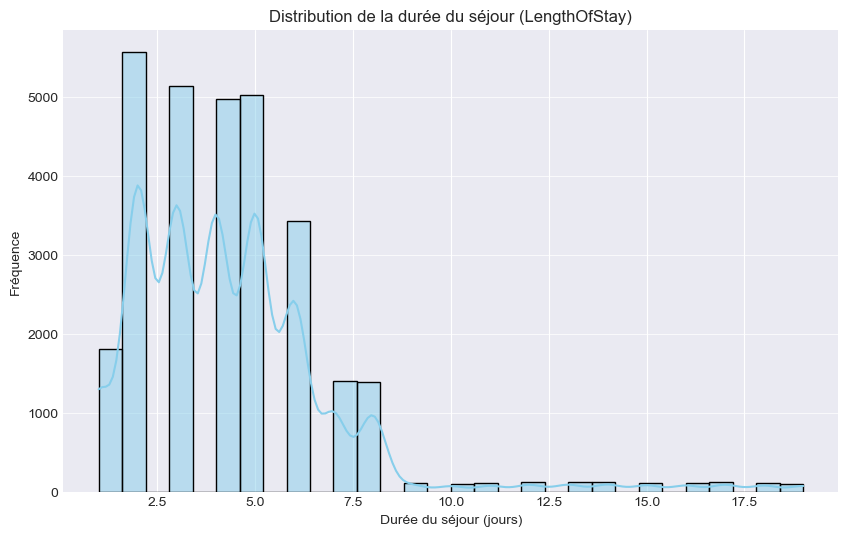

In [209]:
#graphe de la variable cible avec la densité
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution de la durée du séjour (LengthOfStay)")
plt.xlabel("Durée du séjour (jours)")
plt.ylabel("Fréquence")
plt.grid(axis='y', alpha=0.75)
plt.show()

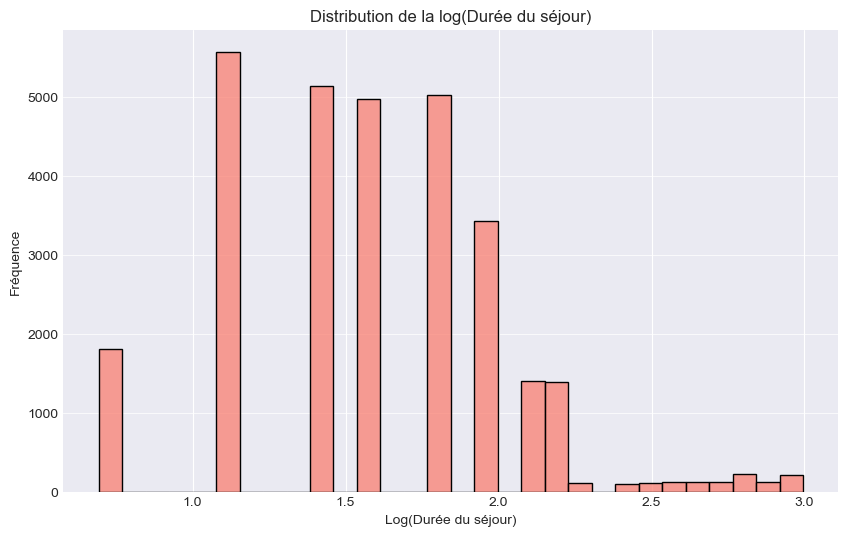

In [210]:
#Graphe de la log(variable cible) sans la densité
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(y), bins=30, kde=False, color='salmon', edgecolor='black')
plt.title("Distribution de la log(Durée du séjour)")
plt.xlabel("Log(Durée du séjour)")
plt.ylabel("Fréquence")
plt.grid(axis='y',alpha=0.75)
plt.show()

## 2.3 Lien des variables numériques avec la variable cible

In [211]:
# ============================================================================
# NUMERICAL FEATURES DEEP DIVE
# ============================================================================

print_divider("NUMERICAL FEATURES ANALYSIS", style="=")
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_num = df_num.drop(columns=['smoking','alcohol','family_history','lengthofstay'])  # Exclude target variable
numerical_features = df_num.columns.tolist()
print(numerical_features)


========================= NUMERICAL FEATURES ANALYSIS =========================
['age', 'glucose', 'blood_pressure', 'bmi', 'oxygen_saturation', 'cholesterol', 'triglycerides', 'hba1c', 'physical_activity', 'diet_score', 'stress_level', 'sleep_hours']


In [212]:

# Create comprehensive analysis for each numerical feature
for feature in numerical_features:
    print_divider(f"Analysis of {feature.upper()}", style="-")
    
    # Statistics
    print(f"📊 Statistics for {feature}:")
    print(f"  Mean: {df[feature].mean():.2f}")
    print(f"  Median: {df[feature].median():.2f}")
    print(f"  Std Dev: {df[feature].std():.2f}")
    print(f"  Min: {df[feature].min():.0f}")
    print(f"  Max: {df[feature].max():.0f}")
    print(f"  Skewness: {df[feature].skew():.3f}")
    print(f"  Kurtosis: {df[feature].kurtosis():.3f}")

    #Enlever les Nans pour les calculs statistiques
    idx_nan = df[feature].isna()
    df_sans_nan = df[~idx_nan]
    y_sans_nan = y[~idx_nan]
    # Correlation with target
    correlation, p_value = pearsonr(df_sans_nan[feature], y_sans_nan)
    print(f"\n📈 Relationship with Charges:")
    print(f"  Pearson Correlation: {correlation:.3f} (p-value: {p_value:.6f})")
    
    spearman_corr, spearman_p = spearmanr(df[feature], y)
    print(f"  Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.6f})")
    
    # Interpretation
    if abs(correlation) > 0.7:
        strength = "Strong"
    elif abs(correlation) > 0.4:
        strength = "Moderate"
    elif abs(correlation) > 0.2:
        strength = "Weak"
    else:
        strength = "Very Weak"
    
    direction = "positive" if correlation > 0 else "negative"
    print(f"  → {strength} {direction} linear relationship with length of stay.")


------------------------------- Analysis of AGE -------------------------------
📊 Statistics for age:
  Mean: 54.62
  Median: 55.00
  Std Dev: 15.97
  Min: 10
  Max: 89
  Skewness: -0.320
  Kurtosis: -0.314

📈 Relationship with Charges:
  Pearson Correlation: 0.111 (p-value: 0.000000)
  Spearman Correlation: nan (p-value: nan)
  → Very Weak positive linear relationship with length of stay.

----------------------------- Analysis of GLUCOSE -----------------------------
📊 Statistics for glucose:
  Mean: 123.62
  Median: 110.50
  Std Dev: 41.58
  Min: 20
  Max: 319
  Skewness: 1.355
  Kurtosis: 1.413

📈 Relationship with Charges:
  Pearson Correlation: 0.231 (p-value: 0.000000)
  Spearman Correlation: nan (p-value: nan)
  → Weak positive linear relationship with length of stay.

-------------------------- Analysis of BLOOD_PRESSURE --------------------------
📊 Statistics for blood_pressure:
  Mean: 140.46
  Median: 138.32
  Std Dev: 21.08
  Min: 74
  Max: 226
  Skewness: 0.465
  Kurtosi

Peu de corrélation directe entre les variables numériques et la variable cible.

# 3 Lien entre les données

## 3.1 Etude des valeurs manquantes

In [213]:
print_divider("Missing Values Analysis", style="=")
#organiser ça sous la forme d'un df premère colonne le nombre de NaN, deuxième colonne le nombre de lignes avec ce nombre de NaN, troisième colonne le pourcentage de lignes avec ce nombre de NaN
missing_values = df.isna().sum(axis=1).value_counts().head(10)
missing_values_df = pd.DataFrame(missing_values)
missing_values_df.columns = ['Number of Rows']
missing_values_df.index.name = 'Number of Missing Values'
missing_values_df['Percentage of Rows'] = (missing_values_df['Number of Rows'] / len(df) * 100).round(2)
display(missing_values_df)



=========================== Missing Values Analysis ===========================


Number of Rows  Percentage of Rows
Number of Missing Values                                    
0                                  13355               44.52
1                                  11675               38.92
2                                   4152               13.84
3                                    753                2.51
4                                     63                0.21
5                                      2                0.01

In [214]:
#Etude des variables ayant des Nan dans leurs valeurs
for feature in df.columns[df.isna().any()]:
    print(f"Analyse de la variable : {feature}")
    print(f"type : {df[feature].dtype}")
    print("-" * 40)

Analyse de la variable : age
type : float64
----------------------------------------
Analyse de la variable : gender
type : object
----------------------------------------
Analyse de la variable : medical_condition
type : object
----------------------------------------
Analyse de la variable : glucose
type : float64
----------------------------------------
Analyse de la variable : blood_pressure
type : float64
----------------------------------------


In [215]:
#Séparation des catégorielles et des numériques
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = df.select_dtypes(include=numerics).columns.tolist()

## 3.2 Etude des correlations entre les variables numériques


============ Etude des correlations entre les variables numériques ============


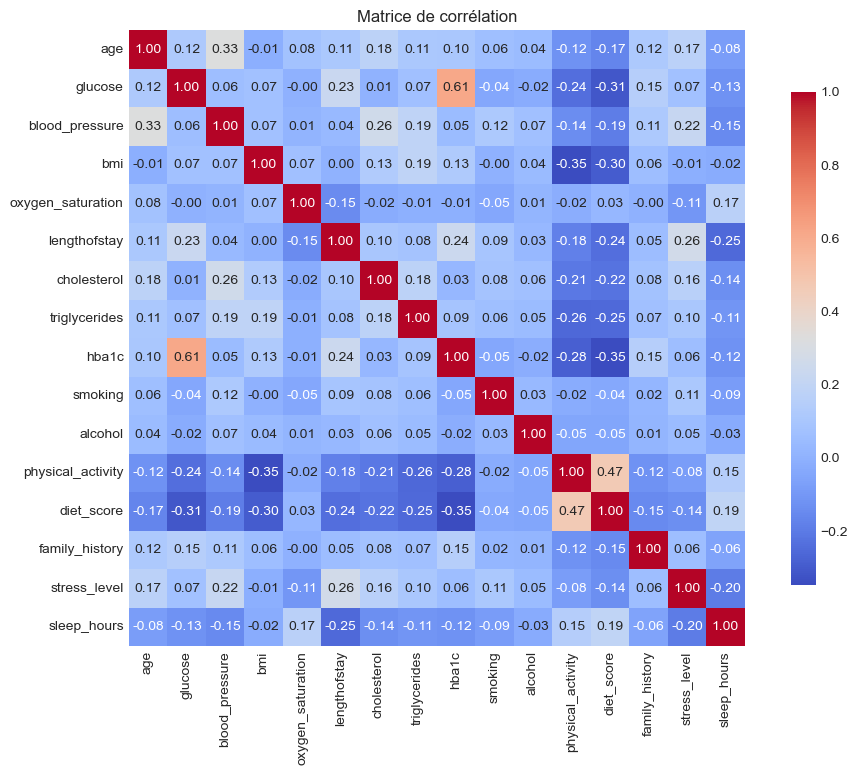

In [216]:
print_divider("Etude des correlations entre les variables numériques", style="=")
#matrice heatmap de corrélations
corr_matrix = df[num_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Matrice de corrélation")
plt.show()

Explained variance ratio by each principal component:


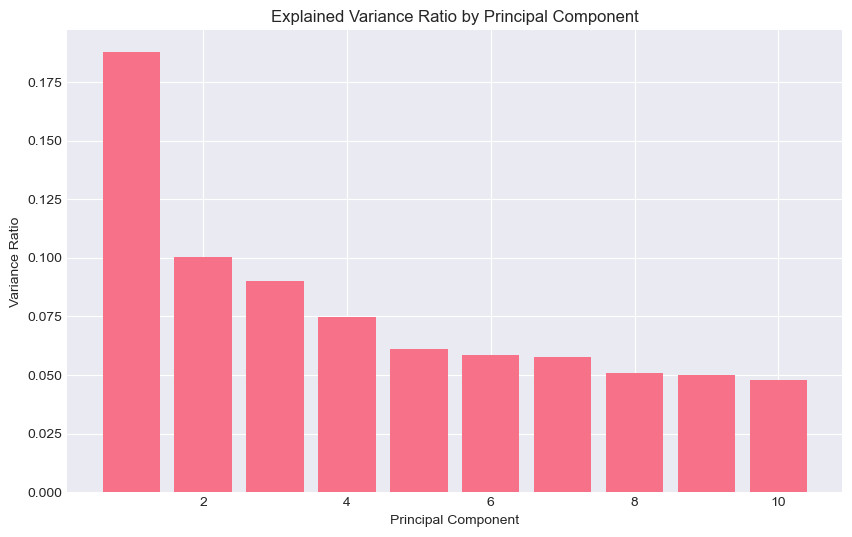

In [219]:
#PCA sur les variables numériques pour voir si on peut réduire la dimensionnalité
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_num = df[num_features].dropna()  # Drop rows with NaNs for PCA
scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)

pca = PCA(n_components=10)
df_pca = pca.fit_transform(df_num_scaled)
print("Explained variance ratio by each principal component:")

fig , ax = plt.subplots(figsize=(10, 6))
ax.bar(range(1,11), pca.explained_variance_ratio_)
ax.set_title("Explained Variance Ratio by Principal Component")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Ratio")
plt.show()


Pas de réduction de dimension envisageable par ACP, les variables sont peu corrélées entre elles.

In [220]:
# VIF for multicollinearity
print("\n📊 Variance Inflation Factor (Multicollinearity Check):")
vif_data = calculate_vif(df.dropna(), numerical_features)
display(vif_data)

if (vif_data['VIF'] > 10).any():
    print("⚠️ Warning: High multicollinearity detected (VIF > 10)")
elif (vif_data['VIF'] > 5).any():
    print("⚠️ Moderate multicollinearity detected (VIF > 5)")
else:
    print("✅ No significant multicollinearity detected (all VIF < 5)")


📊 Variance Inflation Factor (Multicollinearity Check):


Feature         VIF
4   oxygen_saturation  187.159123
2      blood_pressure   54.656871
5         cholesterol   44.970405
7               hba1c   39.726758
11        sleep_hours   32.026195
3                 bmi   29.947859
1             glucose   16.544338
6       triglycerides   16.182242
0                 age   15.091999
10       stress_level    8.939029
9          diet_score    8.770032
8   physical_activity    6.410298

⚠️ Warning: High multicollinearity detected (VIF > 10)


Vif très élevé, il faudra penser à mettre une pénalité L1 ou L2 dans les modèles linéaires.

## 3.2 Etude des variables catégorielles

In [222]:
print_divider("Etude des variables catégorielles", style="=")

print_divider("Liste des variables catégorielles", style="-")
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features = cat_features + ['smoking', 'alcohol', 'family_history']  # Ajouter la variable cible aux catégorielles pour l'analyse
print(cat_features)



====================== Etude des variables catégorielles ======================

---------------------- Liste des variables catégorielles ----------------------
['gender', 'medical_condition', 'smoking', 'alcohol', 'family_history']


In [224]:


print_divider("Analyse des variables catégorielles", style="-")

for feature in cat_features:
    print_divider(f"Analysis of {feature.upper()}", style="-")
    
    # Value counts
    print(f"📊 Distribution of {feature}:")
    value_counts = df[feature].value_counts()
    for category, count in value_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")
    
    # Statistics by category
    print(f"\n📈 LengthOfStay Statistics by {feature}:")
    stats_by_category = df.groupby(feature)['lengthofstay'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    display(stats_by_category)
    
    # ANOVA test
    groups = [group['lengthofstay'].values for name, group in df.groupby(feature)]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\n🔬 ANOVA Test:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"  → Significant difference in Length Of Stay across {feature} categories (p < 0.05)")
    else:
        print(f"  → No significant difference in Length Of Stay across {feature} categories")
    
    # Effect size (Eta-squared)
    ss_between = sum(len(group) * (group.mean() - df['lengthofstay'].mean())**2
                    for group in groups)
    ss_total = sum((df['lengthofstay'] - df['lengthofstay'].mean())**2)
    eta_squared = ss_between / ss_total
    print(f"  Effect size (η²): {eta_squared:.4f}")
    
    if eta_squared > 0.14:
        effect = "Large"
    elif eta_squared > 0.06:
        effect = "Medium"
    else:
        effect = "Small"
    print(f"  → {effect} effect size")


--------------------- Analyse des variables catégorielles ---------------------

------------------------------ Analysis of GENDER ------------------------------
📊 Distribution of gender:
  female: 12865 (42.9%)
  male: 12635 (42.1%)

📈 LengthOfStay Statistics by gender:


count  mean  median   std  min  max
gender                                     
female  12865  4.40     4.0  2.78    1   19
male    12635  4.43     4.0  2.75    1   19


🔬 ANOVA Test:
  F-statistic: 0.5620
  P-value: 0.453448
  → No significant difference in Length Of Stay across gender categories
  Effect size (η²): 0.0000
  → Small effect size

------------------------ Analysis of MEDICAL_CONDITION ------------------------
📊 Distribution of medical_condition:
  hypertension: 7120 (23.7%)
  diabetes: 6417 (21.4%)
  obesity: 3857 (12.9%)
  healthy: 3039 (10.1%)
  asthma: 2037 (6.8%)
  arthritis: 1796 (6.0%)
  cancer: 1234 (4.1%)

📈 LengthOfStay Statistics by medical_condition:


count   mean  median   std  min  max
medical_condition                                      
arthritis           1796   3.48     3.0  1.12    2    5
asthma              2037   3.97     4.0  1.43    2    6
cancer              1234  12.96    13.0  3.70    7   19
diabetes            6417   5.52     6.0  1.71    3    8
healthy             3039   1.49     1.0  0.50    1    2
hypertension        7120   4.01     4.0  1.42    2    6
obesity             3857   3.51     4.0  1.12    2    5


🔬 ANOVA Test:
  F-statistic: 8932.4381
  P-value: 0.000000
  → Significant difference in Length Of Stay across medical_condition categories (p < 0.05)
  Effect size (η²): 0.5687
  → Large effect size

----------------------------- Analysis of SMOKING -----------------------------
📊 Distribution of smoking:
  0: 21607 (72.0%)
  1: 8393 (28.0%)

📈 LengthOfStay Statistics by smoking:


count  mean  median   std  min  max
smoking                                     
0        21607  4.25     4.0  2.58    1   19
1         8393  4.83     4.0  3.14    1   19


🔬 ANOVA Test:
  F-statistic: 271.0711
  P-value: 0.000000
  → Significant difference in Length Of Stay across smoking categories (p < 0.05)
  Effect size (η²): 0.0090
  → Small effect size

----------------------------- Analysis of ALCOHOL -----------------------------
📊 Distribution of alcohol:
  0: 22844 (76.1%)
  1: 7156 (23.9%)

📈 LengthOfStay Statistics by alcohol:


count  mean  median   std  min  max
alcohol                                     
0        22844  4.37     4.0  2.72    1   19
1         7156  4.57     4.0  2.88    1   19


🔬 ANOVA Test:
  F-statistic: 29.2230
  P-value: 0.000000
  → Significant difference in Length Of Stay across alcohol categories (p < 0.05)
  Effect size (η²): 0.0010
  → Small effect size

-------------------------- Analysis of FAMILY_HISTORY --------------------------
📊 Distribution of family_history:
  0: 16817 (56.1%)
  1: 13183 (43.9%)

📈 LengthOfStay Statistics by family_history:


count  mean  median   std  min  max
family_history                                     
0               16817  4.29     4.0  2.99    1   19
1               13183  4.57     4.0  2.43    1   19


🔬 ANOVA Test:
  F-statistic: 79.1659
  P-value: 0.000000
  → Significant difference in Length Of Stay across family_history categories (p < 0.05)
  Effect size (η²): 0.0026
  → Small effect size


In [225]:
# ============================================================================
# CATEGORICAL FEATURES VISUALIZATION
# ============================================================================

# Defensive handling: ensure we have at least one categorical feature
n_rows = max(1, len(cat_features))

# Create subplots for categorical analysis
fig = make_subplots(
    rows=n_rows, cols=3,
    subplot_titles=[f'{feat} - {plot}' 
                    for feat in cat_features 
                    for plot in ['Distribution', 'LengthOfStay Box Plot', 'LengthOfStay Violin Plot']],
    specs=[[{'type': 'bar'}, {'type': 'box'}, {'type': 'violin'}]
           for _ in range(n_rows)],
)

# Adjust height based on number of rows
fig_height = max(600, 300 * n_rows)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

for idx, feature in enumerate(cat_features, 1):
    # Bar plot for distribution
    value_counts = df[feature].value_counts()
    fig.add_trace(
        go.Bar(x=value_counts.index, y=value_counts.values,
              marker_color=colors[:len(value_counts.index)], showlegend=False),
        row=idx, col=1,
    )
    
    # Box plot for LengthOfStay by category
    for category in df[feature].unique():
        fig.add_trace(
            go.Box(y=df[df[feature] == category]['lengthofstay'],
                  name=str(category), showlegend=False),
            row=idx, col=2,
        )
    
    # Violin plot for LengthOfStay by category
    for category in df[feature].unique():
        fig.add_trace(
            go.Violin(y=df[df[feature] == category]['lengthofstay'],
                     name=str(category), showlegend=False),
            row=idx, col=3,
        )

fig.update_layout(height=fig_height, title_text="Comprehensive Categorical Features Analysis")
fig.show()

On conclut de cette analyse que la principale variable catégorielle influençant la durée du séjour est son affection à telle ou telle maladie. 

- La variable "Medical Condition" doit être prise en compte dans les modèles prédictifs de la durée de séjour hospitalier.
- Le fait d'être fumeur, ou alcoolique a une influence, mais moindre, sur la durée du séjour.
- Les antécédents ont une influence modérée sur la durée du séjour.
- Le genre n'a pas d'influence significative sur la durée du séjour.

In [226]:
df.columns

Index(['age', 'gender', 'medical_condition', 'glucose', 'blood_pressure',
       'bmi', 'oxygen_saturation', 'lengthofstay', 'cholesterol',
       'triglycerides', 'hba1c', 'smoking', 'alcohol', 'physical_activity',
       'diet_score', 'family_history', 'stress_level', 'sleep_hours'],
      dtype='object')

# 4. Features Engineering

## 4.1 Nouvelles variables

In [227]:
print_divider("Création d'un nouveau dataframe sans la variable cible", style="=")
df_feat = df.copy()


============ Création d'un nouveau dataframe sans la variable cible ============


In [228]:
# BMI Categories (WHO Classification)
df_feat['bmi_category'] = pd.cut(
    df_feat['bmi'],
    bins=[0, 18.5, 25, 30, 35, 40, 100],
    labels=['Underweight', 'Normal', 'Overweight', 
           'Obese_I', 'Obese_II', 'Obese_III']
)

# Simplified BMI risk
df_feat['bmi_risk'] = df_feat['bmi_category'].map({
    'Underweight': 1,
    'Normal': 0,
    'Overweight': 1,
    'Obese_I': 2,
    'Obese_II': 3,
    'Obese_III': 4
})

In [230]:
# Age Groups (Insurance Industry Standard) et mettre Nan si Nan dans Age
df_feat['age'] = pd.to_numeric(df_feat['age'], errors='coerce')

df_feat['age_group'] = pd.cut(
    df_feat['age'],
    bins=[17, 25, 35, 45, 55, 65],
    labels=['18-25', '26-35', '36-45', '46-55', '56-64'],
    include_lowest=True
)

# Age risk score
df_feat['age_risk'] = pd.cut(
    df_feat['age'],
    bins=[17, 30, 40, 50, 60, 65],
    labels=[1, 2, 3, 4, 5]
)



## 5.2 Sélection de variables

In [232]:
print_divider("Sélection de variables pour le modèle", style="=")

# Prepare data for feature selection
df_feat.dropna(inplace=True)
X = df_feat.drop(['lengthofstay'], axis=1)
y = df_feat['lengthofstay']

# IMPORTANT: Re-check for ALL categorical columns (including newly created ones)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

print(f"📊 Categorical columns: {list(categorical_cols)}")
print(f"📊 Numerical columns: {len(numerical_cols)} columns : {list(numerical_cols)}")


==================== Sélection de variables pour le modèle ====================
📊 Categorical columns: ['gender', 'medical_condition', 'bmi_category', 'age_group', 'age_risk']
📊 Numerical columns: 16 columns : ['age', 'glucose', 'blood_pressure', 'bmi', 'oxygen_saturation', 'cholesterol', 'triglycerides', 'hba1c', 'smoking', 'alcohol', 'physical_activity', 'diet_score', 'family_history', 'stress_level', 'sleep_hours', 'bmi_risk']


In [235]:
# Encode ALL categorical variables
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
label_encoders = {}

# Encode each categorical column
for col in categorical_cols:
   le = LabelEncoder()
   # Handle different column types
   if X_encoded[col].dtype.name == 'category':
        # For categorical columns, convert to string first
        X_encoded[col] = X_encoded[col].astype(str)
    
    # Replace NaN with 'missing' string (now safe for all column types)
   X_encoded[col] = X_encoded[col].fillna('missing')

   # Encode the column
   X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
   label_encoders[col] = le

print(f"\n✅ Encoded {len(categorical_cols)} categorical columns")

# Verify all columns are numeric now
non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"⚠️ Warning: Still have non-numeric columns: {list(non_numeric)}")
    # Force encode any remaining non-numeric columns
    for col in non_numeric:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
else:
    print("✅ All columns are now numeric")


✅ Encoded 5 categorical columns
✅ All columns are now numeric


In [234]:
X_encoded.head()

age  gender  medical_condition  glucose  blood_pressure    bmi  \
0   46.0       1                  3   137.04          135.27  28.90   
1   22.0       1                  4    71.58          113.27  26.29   
5   50.0       1                  5   107.00          171.80  25.33   
11  32.0       1                  4   114.41          122.99  24.92   
13  60.0       1                  5    92.30          128.30  27.33   

    oxygen_saturation  cholesterol  triglycerides  hba1c  ...  alcohol  \
0               96.04       231.88         210.56   7.61  ...        0   
1               97.54       165.57         129.41   4.91  ...        0   
5               95.21       233.10         203.67   5.48  ...        0   
11              95.71       153.71         135.57   4.77  ...        0   
13              96.30       198.27         164.57   4.30  ...        0   

    physical_activity  diet_score  family_history  stress_level  sleep_hours  \
0               -0.20        3.54               0          5.07         6.05   
1                8.12        5.90               0          5.87         7.72   
5                5.01        4.65               0          7.25         6.35   
11               4.92        6.55               1          3.40         7.99   
13               6.78        2.95               1          6.60         7.24   

    bmi_category  bmi_risk  age_group  age_risk  
0              4         1          3         2  
1              4         1          0         0  
5              4         1          3         2  
11             0         0          1         1  
13             4         1          4         3  

[5 rows x 21 columns]


🔍 Calculating Mutual Information Scores...

📊 Top 20 Features by Mutual Information:


Feature  MI Score
2   medical_condition  0.648182
9               hba1c  0.210940
3             glucose  0.170713
13         diet_score  0.166961
12  physical_activity  0.166776
4      blood_pressure  0.094502
8       triglycerides  0.093487
16        sleep_hours  0.085656
7         cholesterol  0.084521
15       stress_level  0.069205
0                 age  0.065567
5                 bmi  0.065510
17       bmi_category  0.063448
6   oxygen_saturation  0.051471
18           bmi_risk  0.049114
19          age_group  0.043575
20           age_risk  0.035649
14     family_history  0.027871
10            smoking  0.014018
11            alcohol  0.009232

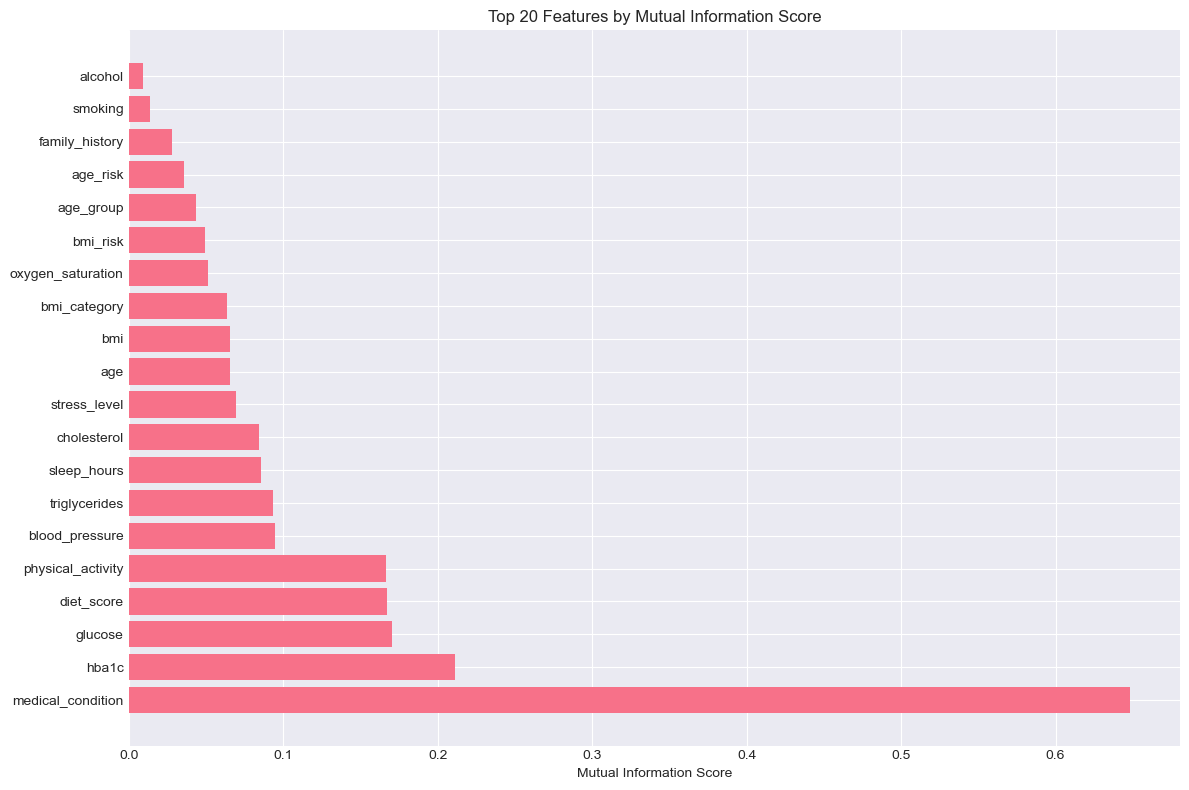

In [236]:
# ====================================================================
# MUTUAL INFORMATION SCORES
# ====================================================================
print("\n🔍 Calculating Mutual Information Scores...")

from sklearn.feature_selection import mutual_info_regression

# Now this should work without errors
mi_scores = mutual_info_regression(X_encoded, y, random_state=RANDOM_STATE)
mi_scores_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)

# Display top 20 features
print("\n📊 Top 20 Features by Mutual Information:")
display(mi_scores_df.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = mi_scores_df.head(20)
plt.barh(range(len(top_features)), top_features['MI Score'].values)
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Features by Mutual Information Score')
plt.tight_layout()
plt.show()

In [237]:
# ====================================================================
# RANDOM FOREST FEATURE IMPORTANCE
# ====================================================================
print("\n🌲 Training Random Forest for Feature Importance...")

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_encoded, y)

# Get feature importances
rf_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 20 Features by Random Forest Importance:")
display(rf_importance_df.head(20))


🌲 Training Random Forest for Feature Importance...

📊 Top 20 Features by Random Forest Importance:


Feature  Importance
2   medical_condition    0.689631
6   oxygen_saturation    0.026581
4      blood_pressure    0.026286
12  physical_activity    0.025855
13         diet_score    0.025753
3             glucose    0.025451
7         cholesterol    0.025321
16        sleep_hours    0.024795
9               hba1c    0.023771
15       stress_level    0.023689
8       triglycerides    0.023635
5                 bmi    0.023228
0                 age    0.016207
17       bmi_category    0.003039
1              gender    0.002924
10            smoking    0.002718
14     family_history    0.002477
11            alcohol    0.002409
20           age_risk    0.002371
19          age_group    0.002221

In [282]:
X['medical_condition'].unique()

array(['diabetes', 'healthy', 'asthma', 'obesity', 'hypertension',
       'cancer', nan, 'arthritis'], dtype=object)

In [239]:
# ====================================================================
# SELECT FINAL FEATURES
# ====================================================================
print("\n🎯 Selecting Final Features...")

# Combine both importance measures
importance_combined = pd.merge(
    mi_scores_df, 
    rf_importance_df, 
    on='Feature'
)

# Normalize scores to 0-1 range
importance_combined['MI_normalized'] = (importance_combined['MI Score'] / 
                                        importance_combined['MI Score'].max())
importance_combined['RF_normalized'] = (importance_combined['Importance'] / 
                                        importance_combined['Importance'].max())

# Combined score (average of both)
importance_combined['Combined_Score'] = (importance_combined['MI_normalized'] + 
                                         importance_combined['RF_normalized']) / 2

importance_combined = importance_combined.sort_values('Combined_Score', ascending=False)

print("\n📊 Top 20 Features by Combined Importance:")
display(importance_combined[['Feature', 'Combined_Score']].head(20))

# Select features above threshold
threshold = 0.1  # Select features with combined score > 0.1
selected_features = importance_combined[importance_combined['Combined_Score'] > threshold]['Feature'].tolist()

# Always include original important features
must_have_features = ['age', 'bmi', 'smoking', 'alcohol', 'gender']
for feature in must_have_features:
    if feature not in selected_features:
        selected_features.append(feature)

print(f"\n✅ Selected {len(selected_features)} features for modeling")
print(f"📝 Selected features: {selected_features}")

# Create final feature set
X_selected = X_encoded[selected_features]

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING & SELECTION COMPLETE!")
print(f"📊 Final feature set: {X_selected.shape}")
print("="*80)


🎯 Selecting Final Features...

📊 Top 20 Features by Combined Importance:


Feature  Combined_Score
0   medical_condition        1.000000
1               hba1c        0.179951
2             glucose        0.150139
3          diet_score        0.147464
4   physical_activity        0.147395
5      blood_pressure        0.091956
6       triglycerides        0.089251
7         sleep_hours        0.084051
8         cholesterol        0.083557
9        stress_level        0.070559
11                bmi        0.067375
10                age        0.062328
13  oxygen_saturation        0.058976
12       bmi_category        0.051146
14           bmi_risk        0.039073
15          age_group        0.035224
16           age_risk        0.029218
17     family_history        0.023295
18            smoking        0.012784
19            alcohol        0.008868


✅ Selected 10 features for modeling
📝 Selected features: ['medical_condition', 'hba1c', 'glucose', 'diet_score', 'physical_activity', 'age', 'bmi', 'smoking', 'alcohol', 'gender']

✅ FEATURE ENGINEERING & SELECTION COMPLETE!
📊 Final feature set: (9679, 10)


# 5. Machine Learning

In [269]:
print_divider("MACHINE LEARNING MODELS", style="=")

# Prepare data for modeling
X = df[selected_features]
y = df['lengthofstay']

from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(f"✅ Data split into training and testing sets:")
print(f"   - Training set: {X_train.shape}")
print(f"   - Testing set: {X_test.shape}")


=========================== MACHINE LEARNING MODELS ===========================
✅ Data split into training and testing sets:
   - Training set: (24000, 10)
   - Testing set: (6000, 10)


In [270]:
# split train en validation et train
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

print(f"✅ Training set further split into training and validation sets:")
print(f"   - Training set: {X_train.shape}")
print(f"   - Validation set: {X_val.shape}")

✅ Training set further split into training and validation sets:
   - Training set: (19200, 10)
   - Validation set: (4800, 10)


In [278]:
# Imputation et encodage

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler , OneHotEncoder

#Identifying numérical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"📊 Numerical features: {numerical_features}")
print(f"📊 Categorical features: {categorical_features}")

📊 Numerical features: ['hba1c', 'glucose', 'diet_score', 'physical_activity', 'age', 'bmi', 'smoking', 'alcohol']
📊 Categorical features: ['medical_condition', 'gender']


In [283]:
print_divider("création des pipelines de pré-traitement", style="=")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Processing pipeline
preprocessor  = ColumnTransformer(transformers=[
    ('num', numerical_pipeline,numerical_features),
    ('cat',categorical_pipeline,categorical_features)
])

print("✅ Preprocessing pipelines created")

# Fit the preprocessor on training data
preprocessor.fit(X_train)
print("✅ Preprocessing pipelines fitted to training data")

# Transform the datasets
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"\n📊 Processed data shape:")
print(f"  Training: {X_train_processed.shape}")
print(f"  Validation: {X_val_processed.shape}")
print(f"  Test: {X_test_processed.shape}")

feature_names = preprocessor.get_feature_names_out()
print(feature_names)


=================== création des pipelines de pré-traitement ===================
✅ Preprocessing pipelines created
✅ Preprocessing pipelines fitted to training data

📊 Processed data shape:
  Training: (19200, 19)
  Validation: (4800, 19)
  Test: (6000, 19)
['num__hba1c' 'num__glucose' 'num__diet_score' 'num__physical_activity'
 'num__age' 'num__bmi' 'num__smoking' 'num__alcohol'
 'cat__medical_condition_arthritis' 'cat__medical_condition_asthma'
 'cat__medical_condition_cancer' 'cat__medical_condition_diabetes'
 'cat__medical_condition_healthy' 'cat__medical_condition_hypertension'
 'cat__medical_condition_missing' 'cat__medical_condition_obesity'
 'cat__gender_female' 'cat__gender_male' 'cat__gender_missing']


In [ ]:
X_train_processed

## 5.1 Modèles de référence

In [253]:
print_divider("Import des packages nécessaires", style="=")

# Models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    HuberRegressor, RANSACRegressor, TheilSenRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, BaggingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score,
    max_error, median_absolute_error
)

print("✅ Scikit-learn modules loaded")


======================= Import des packages nécessaires =======================
✅ Scikit-learn modules loaded


In [254]:
# On crée une fonction pour évaluer les modèles
import time

# Dictionary to store models and results
models = {}
results = {}

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evaluate regression model performance on training and validation sets
    """

    print(f"\n{'='*60}")
    print(f"Evaluating model: {model.__class__.__name__}")
    print(f"{'='*60}\n")

    #train model
    starting_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - starting_time

    # prédictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics calculation
    metrics = {
        'Model' : model.__class__.__name__,
        'Training Time (s)': training_time,
        'Train_R2' : r2_score(y_train, y_train_pred),
        'Val_R2' : r2_score(y_val, y_val_pred),
        'Train_RMSE' : np.sqrt(mean_squared_error(y_train, y_train_pred, squared=False)),
        'Val_RMSE' : np.sqrt(mean_squared_error(y_val, y_val_pred, squared=False)),
        'Train_MAE' : mean_absolute_error(y_train, y_train_pred),
        'Val_MAE' : mean_absolute_error(y_val, y_val_pred),
        'Train_MAPE' : mean_absolute_percentage_error(y_train, y_train_pred),
        'Val_MAPE' : mean_absolute_percentage_error(y_val, y_val_pred)
    }

    #print results
    print("📊 Performance Metrics:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f'R² - Train : {metrics["Train_R2"]:.3f} | Validation : {metrics["Val_R2"]:.3f}')
    print(f'RMSE - Train : {metrics["Train_RMSE"]:.3f} | Validation : {metrics["Val_RMSE"]:.3f}')
    print(f'MAE - Train : {metrics["Train_MAE"]:.3f} | Validation : {metrics["Val_MAE"]:.3f}')
    print(f'MAPE - Train : {metrics["Train_MAPE"]:.3f} | Validation : {metrics["Val_MAPE"]:.3f}')

    overfitting_score = metrics['Train_R2'] - metrics['Val_R2']
    if overfitting_score > 0.1:
        print(f"⚠️  Warning: Possible overfitting (gap: {overfitting_score:.3f})")
    elif overfitting_score > 0.05:
        print(f"⚠️  Mild overfitting detected (gap: {overfitting_score:.3f})")
    else:
        print(f"✅ No significant overfitting (gap: {overfitting_score:.3f})")
    
    return model, metrics
    

In [255]:
# 1 Régréssion linéaire

linear_model, linear_metrics = evaluate_model(
    LinearRegression(),
    X_train_processed, y_train,
    X_val_processed, y_val)

models['Linear Regression'] = linear_model
results['Linear Regression'] = linear_metrics


Evaluating model: LinearRegression

📊 Performance Metrics:
Training Time: 0.14 seconds
R² - Train : 0.575 | Validation : 0.572
RMSE - Train : 1.339 | Validation : 1.349
MAE - Train : 1.347 | Validation : 1.348
MAPE - Train : 0.386 | Validation : 0.374
✅ No significant overfitting (gap: 0.003)


In [256]:
# 2 Ridge Regression

# Find optimal alpha using cross-validation
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5)
ridge_cv.fit(X_train_processed, y_train)
print(f"\nOptimal Ridge alpha: {ridge_cv.alpha_}")

ridge_model, ridge_metrics = evaluate_model(
    Ridge(alpha=ridge_cv.alpha_),
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['Ridge'] = ridge_model
results['Ridge'] = ridge_metrics


Optimal Ridge alpha: 1.0

Evaluating model: Ridge

📊 Performance Metrics:
Training Time: 0.01 seconds
R² - Train : 0.575 | Validation : 0.572
RMSE - Train : 1.339 | Validation : 1.349
MAE - Train : 1.347 | Validation : 1.348
MAPE - Train : 0.387 | Validation : 0.375
✅ No significant overfitting (gap: 0.003)


In [257]:
#3 Lasso Regression

# Find optimal alpha using cross-validation
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5, random_state=RANDOM_STATE)
lasso_cv.fit(X_train_processed, y_train)
print(f"\nOptimal Lasso alpha: {lasso_cv.alpha_}")

lasso_model, lasso_metrics = evaluate_model(
    Lasso(alpha=lasso_cv.alpha_),
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['Lasso Regression'] = lasso_model
results['Lasso Regression'] = lasso_metrics


Optimal Lasso alpha: 0.001

Evaluating model: Lasso

📊 Performance Metrics:
Training Time: 0.02 seconds
R² - Train : 0.575 | Validation : 0.572
RMSE - Train : 1.339 | Validation : 1.349
MAE - Train : 1.347 | Validation : 1.348
MAPE - Train : 0.387 | Validation : 0.375
✅ No significant overfitting (gap: 0.003)


In [258]:
#4 ElasticNet Regression

from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(cv=5, random_state=RANDOM_STATE, n_jobs=-1)
elastic_cv.fit(X_train_processed, y_train)
print(f"\nOptimal ElasticNet alpha: {elastic_cv.alpha_}")

elastic_model, elastic_metrics = evaluate_model(
    ElasticNet(alpha=elastic_cv.alpha_),
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['ElasticNet'] = elastic_model
results['ElasticNet'] = elastic_metrics


Optimal ElasticNet alpha: 0.0015211187686309127

Evaluating model: ElasticNet

📊 Performance Metrics:
Training Time: 0.11 seconds
R² - Train : 0.575 | Validation : 0.572
RMSE - Train : 1.339 | Validation : 1.350
MAE - Train : 1.347 | Validation : 1.349
MAPE - Train : 0.387 | Validation : 0.376
✅ No significant overfitting (gap: 0.004)


In [259]:
# 5 Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

tree_model, tree_metrics = evaluate_model(
    DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=RANDOM_STATE),
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['Decision Tree'] = tree_model
results['Decision Tree'] = tree_metrics


Evaluating model: DecisionTreeRegressor

📊 Performance Metrics:
Training Time: 0.24 seconds
R² - Train : 0.619 | Validation : 0.551
RMSE - Train : 1.303 | Validation : 1.366
MAE - Train : 1.260 | Validation : 1.355
MAPE - Train : 0.357 | Validation : 0.371
⚠️  Mild overfitting detected (gap: 0.068)


In [260]:
# 6 Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest_model, forest_metrics = evaluate_model(
    RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=10, random_state=RANDOM_STATE, n_jobs=-1),
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['Random Forest'] = forest_model
results['Random Forest'] = forest_metrics


Evaluating model: RandomForestRegressor

📊 Performance Metrics:
Training Time: 9.75 seconds
R² - Train : 0.729 | Validation : 0.584
RMSE - Train : 1.197 | Validation : 1.340
MAE - Train : 1.090 | Validation : 1.329
MAPE - Train : 0.308 | Validation : 0.364
⚠️  Warning: Possible overfitting (gap: 0.144)


In [261]:
# 7 Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gb_model, gb_metrics = evaluate_model(
    GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=RANDOM_STATE),
    X_train_processed, y_train,
    X_val_processed, y_val
)


Evaluating model: GradientBoostingRegressor

📊 Performance Metrics:
Training Time: 13.01 seconds
R² - Train : 0.691 | Validation : 0.576
RMSE - Train : 1.237 | Validation : 1.346
MAE - Train : 1.182 | Validation : 1.342
MAPE - Train : 0.337 | Validation : 0.367
⚠️  Warning: Possible overfitting (gap: 0.115)


In [262]:
# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print_divider("BASELINE MODELS SUMMARY", style="=")

results_df = pd.DataFrame(results).T.round(2)

results_df = results_df.sort_values(by='Val_R2', ascending=False)

print("\n📊 Model Performance Summary:")
display(results_df)


=========================== BASELINE MODELS SUMMARY ===========================

📊 Model Performance Summary:


Model Training Time (s)  Train_R2  \
Random Forest      RandomForestRegressor          9.749379  0.728935   
Linear Regression       LinearRegression          0.140997  0.575419   
Ridge                              Ridge          0.009016  0.575418   
Lasso Regression                   Lasso          0.019156  0.575403   
ElasticNet                    ElasticNet          0.112311   0.57524   
Decision Tree      DecisionTreeRegressor          0.240251  0.619037   

                     Val_R2 Train_RMSE  Val_RMSE Train_MAE   Val_MAE  \
Random Forest       0.58446   1.196962   1.33967  1.090035  1.329266   
Linear Regression    0.5725   1.339067  1.349207    1.3471  1.347615   
Ridge              0.572455   1.339067  1.349242  1.347118  1.347693   
Lasso Regression   0.572307   1.339079  1.349359  1.346903  1.347714   
ElasticNet         0.571587   1.339208  1.349927  1.347485  1.348951   
Decision Tree      0.551167   1.303265  1.365733  1.260281  1.354532   

                  Train_MAPE  Val_MAPE  
Random Forest       0.308104  0.364092  
Linear Regression   0.386493  0.374475  
Ridge               0.386544  0.374535  
Lasso Regression    0.386689  0.374719  
ElasticNet          0.387433  0.375533  
Decision Tree       0.356881  0.370851

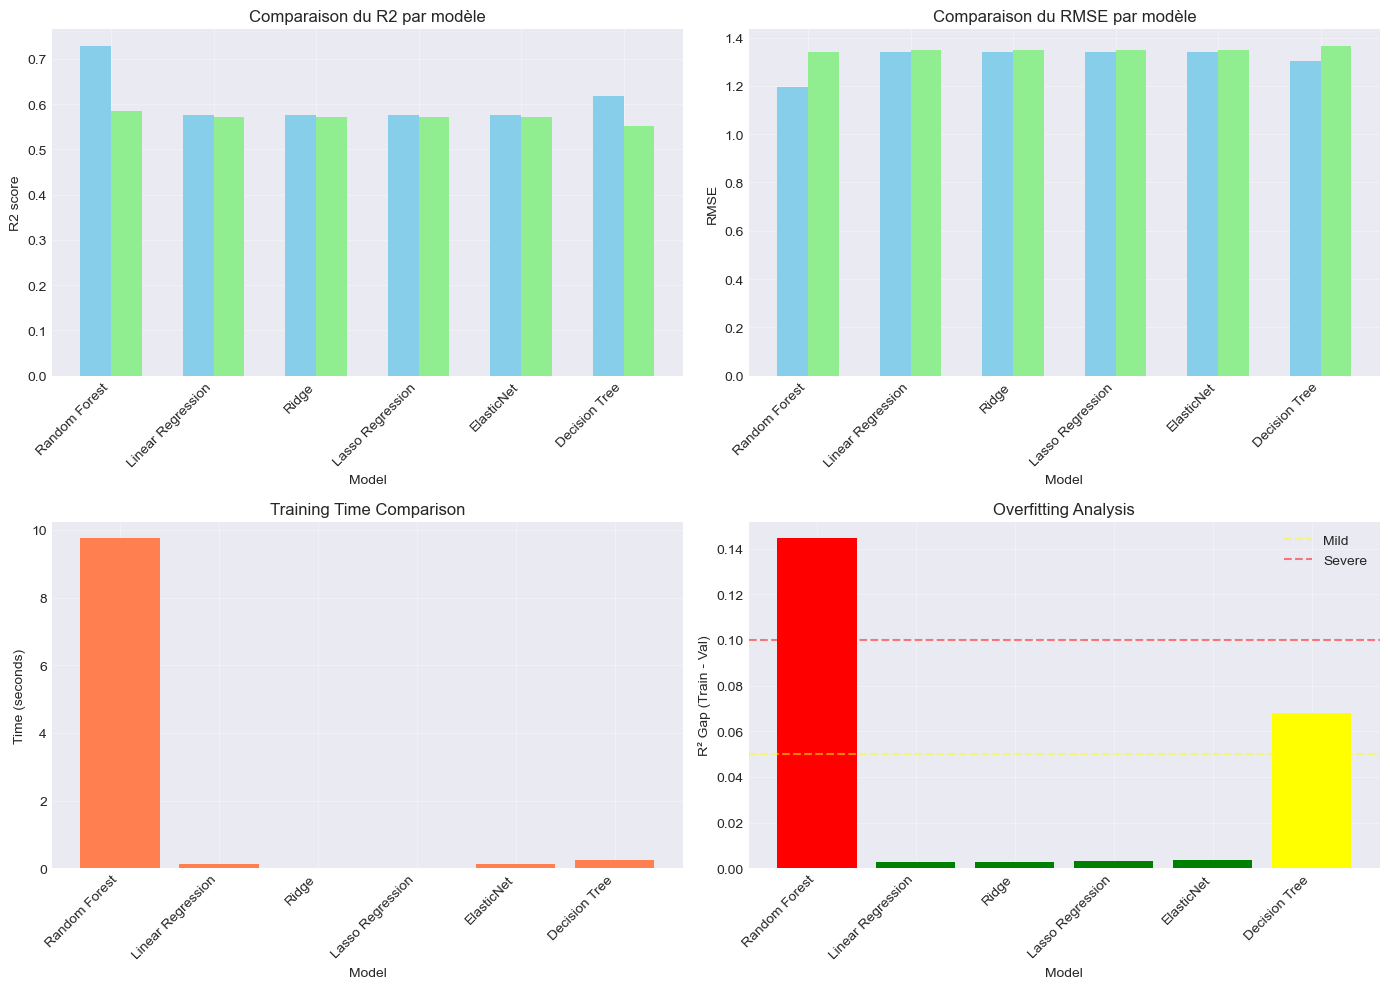


🏆 Best Baseline Model: Random Forest
   Validation R²: 0.5845
   Validation RMSE: 1.34 nuit d'écart


In [263]:
# Visualisation des résultats 

fig, axes = plt.subplots(2,2,figsize=(14,10))

# R2 comparison
ax = axes[0,0]
width=0.3
x = np.arange(len(results_df))
ax.bar(x-width/2, results_df['Train_R2'], color='skyblue', width=width)
ax.bar(x+width/2, results_df['Val_R2'], color='lightgreen', width=width)
ax.legend(['Train R2', 'Validation R2'])
ax.set_title('Comparaison du R2 par modèle')
ax.set_ylabel('R2 score')
ax.set_xlabel('Model')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# RMSE comparison
ax = axes[0,1]
width=0.3
ax.bar(x-width/2, results_df['Train_RMSE'], color='skyblue', width=width)
ax.bar(x+width/2, results_df['Val_RMSE'], color='lightgreen', width=width)
ax.legend(['Train RMSE', 'Validation RMSE'])
ax.set_title('Comparaison du RMSE par modèle')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Training Time
ax = axes[1, 0]
ax.bar(x, results_df['Training Time (s)'], color='coral')
ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Overfitting Analysis
ax = axes[1, 1]
overfitting = results_df['Train_R2'] - results_df['Val_R2']
colors = ['green' if x < 0.05 else 'yellow' if x < 0.1 else 'red' for x in overfitting]
ax.bar(x, overfitting, color=colors)
ax.set_xlabel('Model')
ax.set_ylabel('R² Gap (Train - Val)')
ax.set_title('Overfitting Analysis')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.axhline(y=0.05, color='yellow', linestyle='--', alpha=0.5, label='Mild')
ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Severe')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best baseline model
best_baseline = results_df.iloc[0]
print(f"\n🏆 Best Baseline Model: {best_baseline.name}")
print(f"   Validation R²: {best_baseline['Val_R2']:.4f}")
print(f"   Validation RMSE: {best_baseline['Val_RMSE']:,.2f} nuit d'écart")



## 5.2 Modèle de machine learning avancé


In [264]:
# --- Advanced ML Libraries ---
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool


======================= ADVANCED MACHINE LEARNING MODELS =======================

Training XGBoost with Hyperparameter Tuning...
🔍 Searching for best hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best XGBoost parameters found:
  subsample: 1.0
  n_estimators: 500
  max_depth: 4
  learning_rate: 0.01
  colsample_bytree: 1.0

Evaluating model: XGBRegressor

📊 Performance Metrics:
Training Time: 1.04 seconds
R² - Train : 0.610 | Validation : 0.585
RMSE - Train : 1.311 | Validation : 1.339
MAE - Train : 1.298 | Validation : 1.330
MAPE - Train : 0.369 | Validation : 0.367
✅ No significant overfitting (gap: 0.025)

Training LightGBM with Hyperparameter Tuning...
🔍 Searching for best hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best LightGBM parameters found:
  subsample: 0.8
  num_leaves: 100
  n_estimators: 500
  max_depth: 4
  learning_rate: 0.01

Evaluating model: LGBMRegressor

📊 Performance Metrics:
Training Tim

Model Training Time (s)  Train_R2    Val_R2  \
XGBoost                 XGBRegressor          1.037428   0.61023  0.584749   
CatBoost           CatBoostRegressor          4.342273   0.65632  0.584551   
LightGBM               LGBMRegressor          1.246777  0.606358  0.584479   
Random Forest  RandomForestRegressor          9.749379  0.728935   0.58446   

              Train_RMSE  Val_RMSE Train_MAE   Val_MAE Train_MAPE  Val_MAPE  
XGBoost         1.310732  1.339437  1.297845  1.329896   0.369157  0.367461  
CatBoost        1.270137  1.339597  1.239794  1.332274   0.350951  0.364636  
LightGBM        1.313976  1.339655  1.301217  1.330597   0.368963  0.367617  
Random Forest   1.196962   1.33967  1.090035  1.329266   0.308104  0.364092

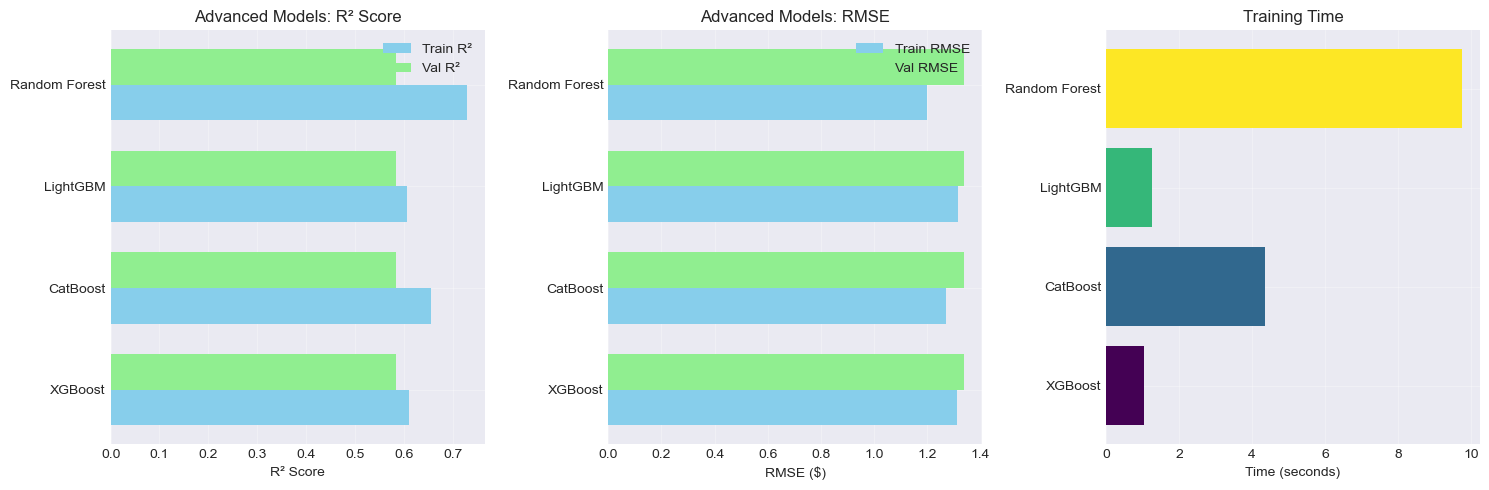


🏆 Best Advanced Model: XGBoost
   Validation R²: 0.5847
   Validation RMSE: 1.34 nuits d'écart


In [265]:
print_divider("ADVANCED MACHINE LEARNING MODELS", style="=")

# ============================================================================
# 1. XGBOOST
# ============================================================================

print("\n" + "="*60)
print("Training XGBoost with Hyperparameter Tuning...")
print("="*60)

# Define parameter grid for XGBoost
xgb_params = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use RandomizedSearchCV for faster search
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)

xgb_random_search = RandomizedSearchCV(
    xgb_model,
    xgb_params,
    n_iter=20,
    cv=3,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("🔍 Searching for best hyperparameters...")
xgb_random_search.fit(X_train_processed, y_train)

print(f"\n✅ Best XGBoost parameters found:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate best XGBoost model
xgb_best = xgb_random_search.best_estimator_
xgb_best_model, xgb_metrics = evaluate_model(
    xgb_best,
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['XGBoost'] = xgb_best_model
results['XGBoost'] = xgb_metrics

# ============================================================================
# 2. LIGHTGBM
# ============================================================================

print("\n" + "="*60)
print("Training LightGBM with Hyperparameter Tuning...")
print("="*60)

lgb_params = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)

lgb_random_search = RandomizedSearchCV(
    lgb_model,
    lgb_params,
    n_iter=20,
    cv=3,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("🔍 Searching for best hyperparameters...")
lgb_random_search.fit(X_train_processed, y_train)

print(f"\n✅ Best LightGBM parameters found:")
for param, value in lgb_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate best LightGBM model
lgb_best = lgb_random_search.best_estimator_
lgb_best_model, lgb_metrics = evaluate_model(
    lgb_best,
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['LightGBM'] = lgb_best_model
results['LightGBM'] = lgb_metrics

# ============================================================================
# 3. CATBOOST
# ============================================================================

print("\n" + "="*60)
print("Training CatBoost...")
print("="*60)

# CatBoost handles categorical features automatically
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_state=RANDOM_STATE,
    verbose=False
)

cat_best_model, cat_metrics = evaluate_model(
    cat_model,
    X_train_processed, y_train,
    X_val_processed, y_val
)
models['CatBoost'] = cat_best_model
results['CatBoost'] = cat_metrics

# ============================================================================
# ADVANCED MODELS COMPARISON
# ============================================================================

print_divider("ADVANCED MODELS COMPARISON", style="=")

# Update results dataframe
advanced_results_df = pd.DataFrame({
    k: v for k, v in results.items() 
    if k in ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest', 'Gradient Boosting']
}).T

advanced_results_df = advanced_results_df.round(2)
advanced_results_df = advanced_results_df.sort_values('Val_R2', ascending=False)

print("\n📊 Advanced Models Performance:")
display(advanced_results_df)

# Visualize advanced models comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R2 Score comparison
ax = axes[0]
models_list = advanced_results_df.index
train_r2 = advanced_results_df['Train_R2']
val_r2 = advanced_results_df['Val_R2']

x = np.arange(len(models_list))
width = 0.35

ax.barh(x - width/2, train_r2, width, label='Train R²', color='skyblue')
ax.barh(x + width/2, val_r2, width, label='Val R²', color='lightgreen')
ax.set_yticks(x)
ax.set_yticklabels(models_list)
ax.set_xlabel('R² Score')
ax.set_title('Advanced Models: R² Score')
ax.legend()
ax.grid(True, alpha=0.3)

# RMSE comparison
ax = axes[1]
train_rmse = advanced_results_df['Train_RMSE']
val_rmse = advanced_results_df['Val_RMSE']

ax.barh(x - width/2, train_rmse, width, label='Train RMSE', color='skyblue')
ax.barh(x + width/2, val_rmse, width, label='Val RMSE', color='lightgreen')
ax.set_yticks(x)
ax.set_yticklabels(models_list)
ax.set_xlabel('RMSE ($)')
ax.set_title('Advanced Models: RMSE')
ax.legend()
ax.grid(True, alpha=0.3)

# Training time
ax = axes[2]
training_times = advanced_results_df['Training Time (s)']
colors = plt.cm.viridis(np.linspace(0, 1, len(training_times)))
ax.barh(x, training_times, color=colors)
ax.set_yticks(x)
ax.set_yticklabels(models_list)
ax.set_xlabel('Time (seconds)')
ax.set_title('Training Time')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🏆 Best Advanced Model: {advanced_results_df.iloc[0].name}")
print(f"   Validation R²: {advanced_results_df.iloc[0]['Val_R2']:.4f}")
print(f"   Validation RMSE: {advanced_results_df.iloc[0]['Val_RMSE']:,.2f} nuits d'écart")

# 6.Sauvegarde du meilleur modèle

In [ ]:
print_divider("Sauvegarde du modèle final", style="=")

import joblib

joblib.dump(xgb_best_model, '../model/best_model.pkl')

print("✅ Modèle sauvegardé sous '../model/best_model.pkl'")

print_divider("Sauvegarde du preprocessor", style="=")
joblib.dump(preprocessor, '../model/preprocessor.pkl')
print("✅ Preprocessor sauvegardé sous '../model/preprocessor.pkl'")


========================== Sauvegarde du modèle final ==========================
✅ Modèle sauvegardé sous '../model/xgb_best_model.pkl'

========================== Sauvegarde du preprocessor ==========================
✅ Preprocessor sauvegardé sous '../model/preprocessor.pkl'


In [2]:
import joblib
model = joblib.load("../model/best_model.pkl")
preprocessor = joblib.load("../model/preprocessor.pkl")
print(type(model))
print(type(preprocessor))

<class 'xgboost.sklearn.XGBRegressor'>
<class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [ ]:
#
#
#print("✅ Core libraries imported successfully")
#
## --- Data Visualization Libraries ---
#import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
#import plotly.io as pio
#
## Set visualization styles for professional output
#plt.style.use('seaborn-v0_8-darkgrid')
#sns.set_palette("husl")
#pio.templates.default = "plotly_white"
#
#print("✅ Visualization libraries configured")
#
## --- Statistical Analysis Libraries ---
#from scipy import stats
#from scipy.stats import normaltest, shapiro, anderson
#from scipy.stats import pearsonr, spearmanr, kendalltau
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#
#print("✅ Statistical libraries loaded")
#
## --- Machine Learning Libraries ---
## Preprocessing
#from sklearn.model_selection import (
#    train_test_split, KFold, StratifiedKFold, 
#    cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
#)
#from sklearn.preprocessing import (
#    StandardScaler, MinMaxScaler, RobustScaler, 
#    QuantileTransformer, PowerTransformer, LabelEncoder, OneHotEncoder
#)
#from sklearn.impute import SimpleImputer, KNNImputer
#from sklearn.feature_selection import (
#    SelectKBest, f_regression, mutual_info_regression,
#    RFE, RFECV, SelectFromModel
#)
#
## Models
#from sklearn.linear_model import (
#    LinearRegression, Ridge, Lasso, ElasticNet,
#    HuberRegressor, RANSACRegressor, TheilSenRegressor
#)
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import (
#    RandomForestRegressor, ExtraTreesRegressor,
#    GradientBoostingRegressor, AdaBoostRegressor,
#    VotingRegressor, StackingRegressor, BaggingRegressor
#)
#from sklearn.svm import SVR
#from sklearn.neighbors import KNeighborsRegressor
#
## Metrics
#from sklearn.metrics import (
#    mean_squared_error, mean_absolute_error, r2_score,
#    mean_absolute_percentage_error, explained_variance_score,
#    max_error, median_absolute_error
#)
#
#print("✅ Scikit-learn modules loaded")
#
## --- Advanced ML Libraries ---
#import xgboost as xgb
#import lightgbm as lgb
#from catboost import CatBoostRegressor, Pool
#
#print("✅ Advanced ML libraries loaded")
#
## --- Deep Learning Libraries ---
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers, models, callbacks, optimizers
##from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#
## Check GPU availability
#print(f"TensorFlow version: {tf.__version__}")
#print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
#
## --- AutoML Libraries ---
#try:
#    from autogluon.tabular import TabularPredictor
#    print("✅ AutoGluon loaded")
#except:
#    print("⚠️ AutoGluon not available")
#
## --- Model Interpretation Libraries ---
#import shap
#from lime.lime_tabular import LimeTabularExplainer
#import eli5
#from eli5.sklearn import PermutationImportance
#
#print("✅ Explainable AI libraries loaded")
#
## --- Utility Functions ---
#import time
#import gc
#from tqdm import tqdm
#tqdm.pandas()
#
## --- Set Random Seeds for Reproducibility ---
#RANDOM_STATE = 42
#np.random.seed(RANDOM_STATE)
#tf.random.set_seed(RANDOM_STATE)
#
#print("\n" + "="*80)
#print("🎉 ALL LIBRARIES LOADED SUCCESSFULLY!")
#print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
#print(f"🔧 Python Version: {sys.version.split()[0]}")
#print(f"📊 Pandas Version: {pd.__version__}")
#print(f"🔢 NumPy Version: {np.__version__}")
#print("="*80)
#

✅ Core libraries imported successfully
✅ Visualization libraries configured
✅ Statistical libraries loaded
✅ Scikit-learn modules loaded
✅ Advanced ML libraries loaded


ModuleNotFoundError: No module named 'tensorflow'